# Практична робота з побудови нечіткої бази знань

## Завдання
Побудувати нечітку базу знань (використовувати не менше 5
лінгвістичних змінних) для завдання розподілу навантажень
спортсмена (співвідношення навантажень, фізичного стану,
споживаних калорій тощо), перевірити її на повноту та
зробити нечіткий висновок для конкретних значень (вибрати
випадковим чином).



## Лінгвістичні змінні

Вхідні параметри (antecedents):  
	1. тривалість тренування без довгих пауз (duration)  
	2. початкова кількість підтягувань (start)  
	3. рівень втоми після останнього тренування (fatigue)  
	4. інтервал відпочинку між підходами (rest_intervals)  
	5. настрій на перемогу або рівень спортивногу духу (morale)  

Передбачені вихідні параметри (consequents):  
Зміна в кількості підтягувань в залежності від режима тренувань і стану спортсмена


_______

## Необхідні бібліотеки

In [15]:
#%pip install scikit-fuzzy
#%pip install numpy
#%pip install matplotlib

In [16]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline

# Модель №1

## Вхідні параметри Модель №1
1. ✅ тривалість тренування без довгих пауз (duration)
2. ✅ початкова кількість разів (initial_reps)

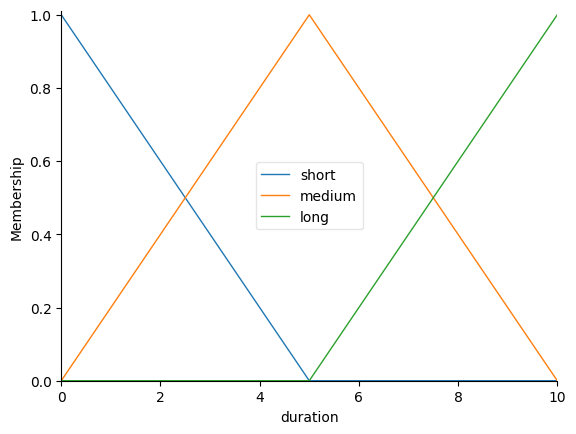

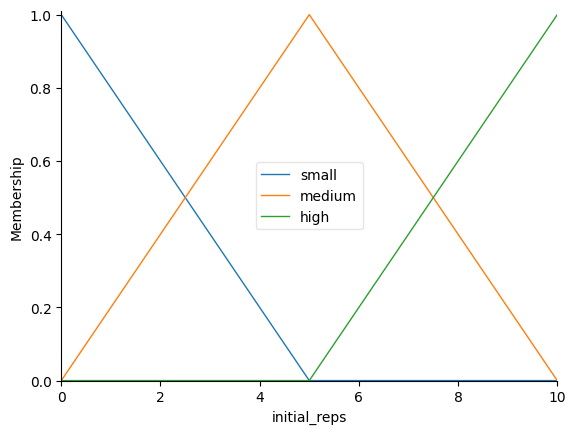

In [17]:
duration = ctrl.Antecedent(np.linspace(0, 10, 5), 'duration')

duration.automf(names=['short', 'medium', 'long'])
duration.view()

initial_reps = ctrl.Antecedent(np.linspace(0, 10, 5), 'initial_reps')
initial_reps.automf(names=['small', 'medium', 'high'])
initial_reps.view()


## Вихідний параметр модель №1
✅ зміна в кількості підтягувань порівнянно з початковим рівнем (delta)

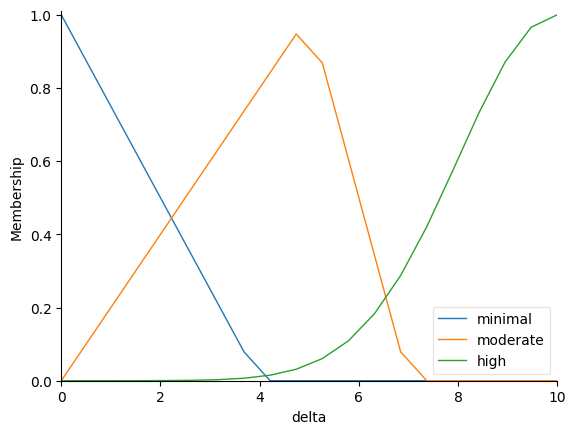

In [18]:
delta = ctrl.Consequent(np.linspace(0, 10, 20), 'delta')

# delta.automf(names=['minimal', 'moderate', 'high'])
delta['minimal'] = fuzz.trimf(delta.universe, [0, 0, 4])
delta['moderate'] = fuzz.trimf(delta.universe, [0, 5, 7])
delta['high'] = fuzz.gaussmf(delta.universe, 10, 2)

delta.view()

## Правила моделі №1
*Спортсмен* отримає
- Мала додаткова кількість підтягувань якщо
    - короткий термін тренувань або велика початкова кількістю підтягувань
- Середня додаткова кількість підтягувань якщо
    - середній термін тренувань і середньою початковою кількістю підтягувань
    - довгий термін тренувань і мала початкова кількістю підтягувань
- Велика додаткова кількість підтягувань якщо
    - довгий термін тренувань і середня початкова кількістю підтягувань

In [19]:
rule1 = ctrl.Rule(
    antecedent=(
        duration['short'] | initial_reps['high']
    ),
    consequent=delta['minimal'],
    label='rule minimal delta')
rule2 = ctrl.Rule(
    antecedent=(
        (duration['medium']) & (initial_reps['medium']) |
        (duration['long']) & (initial_reps['small']) 
    ),
    consequent=delta['moderate'],
    label='rule moderate delta')
rule3 = ctrl.Rule(
    antecedent=(
        duration['long'] & initial_reps['medium']
    ),
    consequent=delta['high'],
    label='rule high delta')

system = ctrl.ControlSystem(rules=[rule1, rule2, rule3])

## Візуалізація залежності між терміном тренувань та початковою кількістю підтягувань

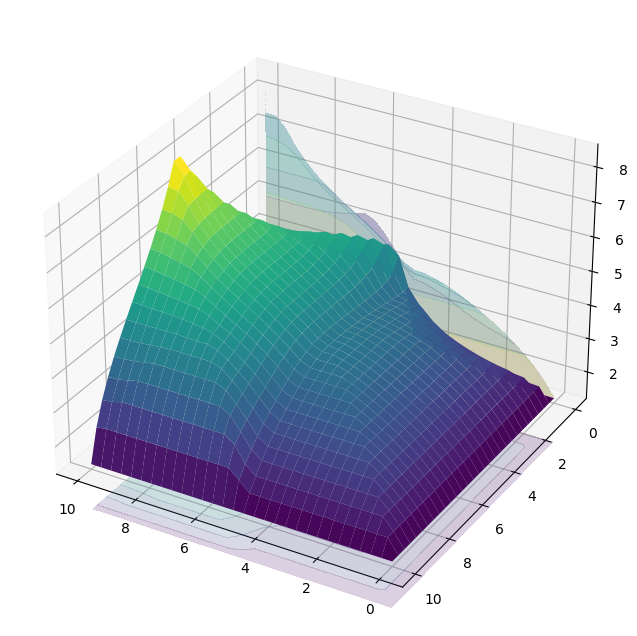

In [20]:

sim = ctrl.ControlSystemSimulation(system)

detalization = 30
x, y = np.meshgrid(np.linspace(0, 10, detalization), np.linspace(0, 10, detalization))
z = np.zeros_like(x)

for i in range(detalization):
    for j in range(detalization):
        sim.input['duration'] = x[i, j]
        sim.input['initial_reps'] = y[i, j]
        sim.compute()
        z[i, j] = sim.output['delta']

# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=0, cmap='viridis', alpha=0.2)
# cset = ax.contourf(x, y, z, zdir='x', offset=0, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=0, cmap='viridis', alpha=0.2)

ax.view_init(30, 120)

## Тестування

### Мала початкова кількість при  найдовшому періоді тренувань

5.254387581750245


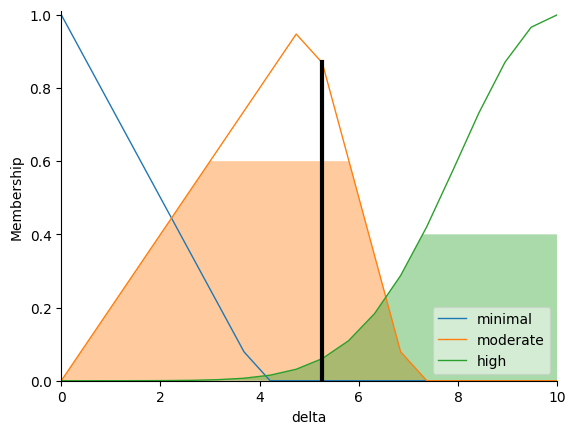

In [21]:
sim = ctrl.ControlSystemSimulation(system)

sim.input['duration'] = 10
sim.input['initial_reps'] = 2
sim.compute()

print(sim.output['delta'])
delta.view(sim=sim)

### Велика початкова кількість при  середньому періоді тренувань

3.9460773205286013


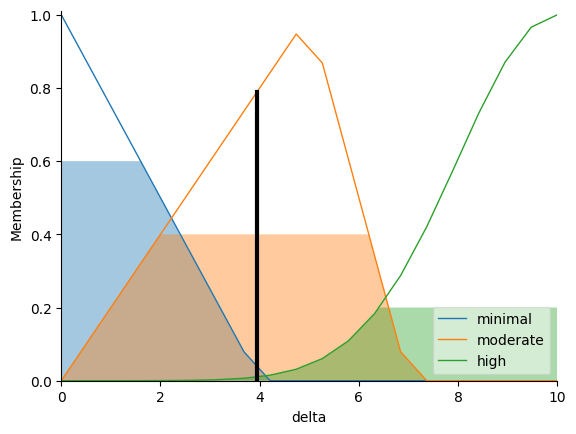

In [22]:
sim = ctrl.ControlSystemSimulation(system)

sim.input['duration'] = 6
sim.input['initial_reps'] = 8
sim.compute()

print(sim.output['delta'])
delta.view(sim=sim)

### Середня початкова кількість при  довгому періоді тренувань

6.740703390635819


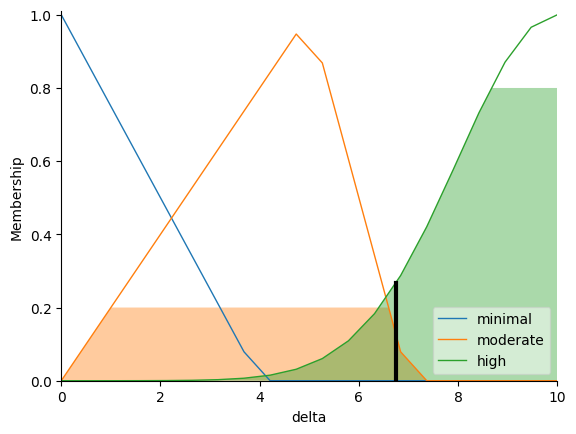

In [23]:
sim = ctrl.ControlSystemSimulation(system)

sim.input['duration'] = 10
sim.input['initial_reps'] = 4
sim.compute()

print(sim.output['delta'])
delta.view(sim=sim)

# Модель №2

## Вхідні параметри модель №2
1. ✅ рівень втоми після останнього тренування (fatigue)
2. ✅ середній інтервал відпочинку між підходами (rest_intervals)
3. ✅ спортивний дух (morale)

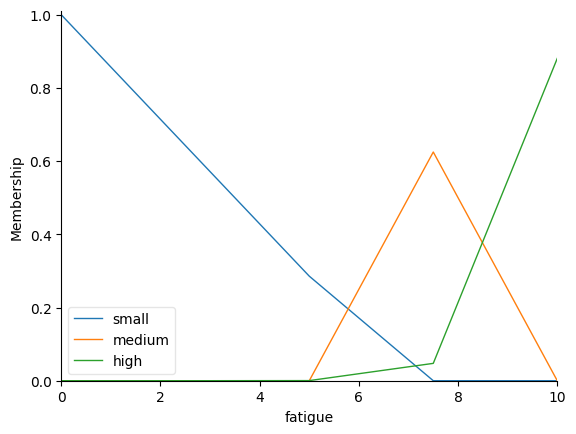

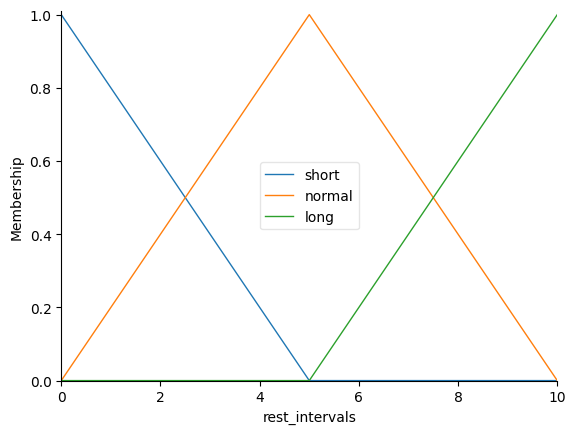

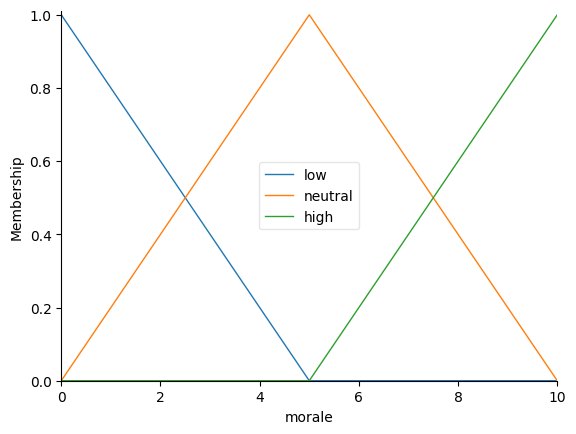

In [24]:
fatigue = ctrl.Antecedent(np.linspace(0, 10, 5), 'fatigue')
# можливо більш точно визначити функції належності
fatigue['small'] = fuzz.trimf(fatigue.universe, [0, 0, 7])
fatigue['medium'] = fuzz.trimf(fatigue.universe, [5, 6, 10])
fatigue['high'] = fuzz.sigmf(duration.universe, 9, 2)
fatigue.view()

rest_intervals = ctrl.Antecedent(np.linspace(0, 10, 5), 'rest_intervals')
rest_intervals.automf(names=['short', 'normal', 'long'])
rest_intervals.view()

morale = ctrl.Antecedent(np.linspace(0, 10, 5), 'morale')
morale.automf(names=['low', 'neutral', 'high'])
morale.view()

## Вихідний параметр модель №2
✅ модифікатор стану спортсмена (shape)

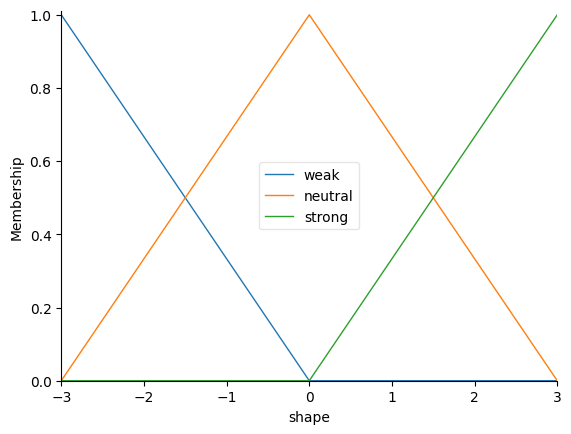

In [25]:
shape = ctrl.Consequent(np.linspace(-3, 3, 5), 'shape')
shape.automf(names=['weak', 'neutral', 'strong'])
shape.view()

## Правила моделі №2

- fatigue.automf(names=['small', 'medium', 'high'])
- rest_intervals.automf(names=['short', 'normal', 'long'])
- morale.automf(names=['low', 'neutral', 'high'])

*Спортсмен* має
- слабку форму 
    - при низькому спортивному духу або великий втомі
- нейтральну форму 
    - при відсутності великої втоми і середньму спортивному духу
    - при великому інтервалі відпочинку і великий втомі
- гарну форму
    - при відсутності великої втоми, достатньому інтервалі відпочинку та високому спортивному духу

In [26]:
rule_2_1 = ctrl.Rule(
    antecedent=(
        morale['low'] | fatigue['high']
    ),
    consequent=shape['weak'],
    label='rule weak shape')
rule_2_2 = ctrl.Rule(
    antecedent=(
        (~fatigue['high']) & (morale['neutral']) |
        (rest_intervals['long']) & (fatigue['high']) 
    ),
    consequent=shape['neutral'],
    label='rule neutral shape')
rule_2_3 = ctrl.Rule(
    antecedent=(
        ~fatigue['high'] & ~rest_intervals['short'] & morale['high']
    ),
    consequent=shape['strong'],
    label='rule strong shape')

system2 = ctrl.ControlSystem(rules=[rule_2_1, rule_2_2, rule_2_3])

## Тестування

0.535712933396696


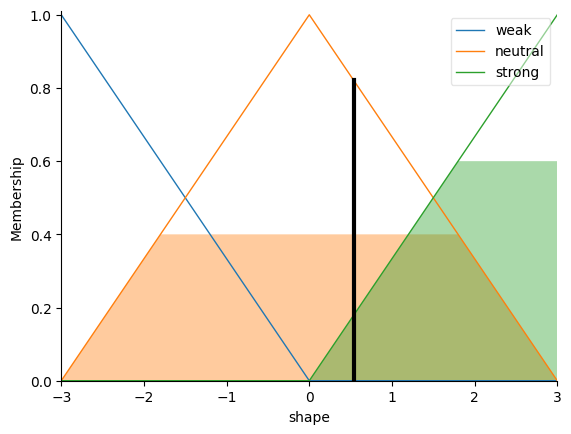

In [27]:
sim2 = ctrl.ControlSystemSimulation(system2)

sim2.input['morale'] = 8
sim2.input['rest_intervals'] = 5
sim2.input['fatigue'] = 2
sim2.compute()

print(sim2.output['shape'])
shape.view(sim=sim2)

# Тестування сукупності моделей

In [28]:

sim.input['duration'] = 10
sim.input['initial_reps'] = 2
sim.compute()
delta_factor = sim.output['delta']

print('### delta_factor: ', delta_factor)

sim2.input['morale'] = 8
sim2.input['rest_intervals'] = 5
sim2.input['fatigue'] = 2
sim2.compute()

shape_factor = sim2.output['shape']
print('### shape_factor', shape_factor)

result = np.rint(delta_factor + shape_factor)
print('### result', result)

### delta_factor:  5.254387581750245
### shape_factor 0.535712933396696
### result 6.0


## Перевірка повноти

Перевірка повноти бази знань, заснованої на нечіткій логіці, може бути виконана за допомогою таких методів:

    Тестування: Створіть тестові набори даних, які включають різні варіанти ситуацій та випадки, які могли б виникнути в реальному житті. Потім використовуйте базу знань для розв'язання цих задач. Якщо база знань добре вирішує більшість тестових випадків, то вона може бути вважати повною.

    Експертна оцінка: Попросіть експертів з досвідом в галузі, пов'язаній з нечіткою логікою, переглянути базу знань та дати свої відгуки про повноту та коректність інформації.

    Порівняння з іншими базами знань: Порівняйте вашу базу знань з іншими базами знань, які вже були перевірені та використовуються в реальних ситуаціях. Це допоможе виявити можливі проблеми та недоліки в вашій базі знань.

    Постійне оновлення: Нечітка логіка залежить від великої кількості факторів, які можуть змінюватись з часом. Тому важливо постійно оновлювати базу знань та перевіряти її на повноту та актуальність.

Отже, перевірка повноти бази знань заснованої на нечіткій логіці може бути виконана за допомогою тестування, експертної оцінки, порівняння з іншими базами знань та постійного оновлення.